# 2. Classify Manhattan with TensorFlow

In this codelab, we will use TensorFlow to train a neural network to predict whether a geolocation is in Manhattan or not, by looking at its longitude and latitude.

<br/>
![](images/manhattan.png)
<br/>
<br/>

### Clear all Cells

Before starting this codelab, please select `Clear all Cells` from the Cloud Datalab menu to clear all the cell outputs.

## 2-1. Importing the training data from BigQuery

At first, we will get a training data from the public dataset on BigQuery. One of the [NYPD Motor Vehicle Collisions Data](https://cloud.google.com/bigquery/public-data/nypd-mv-collisions) which collects all the car accidents happened in NYC from 2012 to the present. 

Let's take a look at the data by executing a BigQuery SQL. In Cloud Datalab, you can execute it by using "%%sql" command (see [this doc](https://github.com/googledatalab/notebooks/tree/master/tutorials/BigQuery) to learn more about the BigQuery commands). **Select the cell below and run the query** by clicking "Run" on the menu.

In [19]:
%%sql -d standard
SELECT
  timestamp,
  borough,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
ORDER BY
  timestamp DESC
LIMIT
  15

timestamp,borough,latitude,longitude
2017-02-21 23:55:00,BRONX,40.883343,-73.8499
2017-02-21 23:47:00,,,
2017-02-21 23:41:00,BROOKLYN,,
2017-02-21 22:58:00,,,
2017-02-21 22:35:00,,,
2017-02-21 22:15:00,BROOKLYN,40.65136,-73.86971
2017-02-21 22:07:00,BROOKLYN,40.676952,-73.888596
2017-02-21 22:03:00,BROOKLYN,40.63593,-74.007195
2017-02-21 21:50:00,,40.803627,-73.963394
2017-02-21 21:50:00,BROOKLYN,40.626545,-73.94101


### Preprocess the training data on BigQuery

In this codelab, we do not care about the car accidents. We just wanted to use the data for getting pairs of "latitude", "longitude" and "Is it Manhattan or not". So, we want to do the following preprocessing on this raw data:

- Add a column "is_mt" that returns 1 or 0 to indicate if the borough is Manhattan or not
- Remove rows without borough info
- Remove rows without longitude/latitude info
- Remove rows for Bronx (as it's too close to Manhattan and hard to classify with single layer neural network!)
- Randomly shuffule all the rows (for making the training data even)
- Select only the 10,000 rows

So, our SQL with the preprocessing will look like the following. **Select the cell below and run it**. Please note that this only defines the SQL module "nyc_collisions" that will be used later and **does not output anything**.

In [20]:
%%sql --module nyc_collisions
SELECT
  IF(borough = 'MANHATTAN', 1, 0) AS is_mt,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  LENGTH(borough) > 0
  AND latitude IS NOT NULL AND latitude != 0.0
  AND longitude IS NOT NULL AND longitude != 0.0
  AND borough != 'BRONX'
ORDER BY
  RAND()
LIMIT
  10000

### Import the BigQuery SQL result as NumPy array

Then, we need to execute the SQL defined above and import the data into Datalab. For this purpose, Datalab provides [BigQuery APIs](https://github.com/googledatalab/notebooks/blob/master/tutorials/BigQuery/BigQuery%20APIs.ipynb) that allows you to execute the define SQL and import the results as a [NumPy](http://www.numpy.org/) array named `nyc_cols`. **Run the cell below** and confirm it loaded 10,000 rows.

In [21]:
import datalab.bigquery as bq
nyc_cols = bq.Query(nyc_collisions).to_dataframe(dialect='standard').as_matrix()
print nyc_cols
print "\nLoaded " + str(len(nyc_cols)) + " rows."

[[  0.         40.6600522 -73.9174184]
 [  0.         40.7534674 -73.9135417]
 [  0.         40.6317075 -73.946481 ]
 ..., 
 [  1.         40.8194253 -73.9555646]
 [  0.         40.770861  -73.9299062]
 [  0.         40.7371576 -73.8794051]]

Loaded 10000 rows.


Let's take a look at what's inside the result. **Run the cell below** and check the variable `is_mt` has an array of 1s and 0s representing each geolocation is in Manhattan or not, and the variable `latlng` has an array of pairs of latitude and longitude.

In [22]:
import numpy as np
is_mt = nyc_cols[:,0].astype(np.int32) # read the 0th column (is_mt) as int32
latlng = nyc_cols[:,1:3].astype(np.float32) # read the 1st and 2nd column (latitude and longitude) as float32
print "Is Manhattan: " + str(is_mt)
print "\nLat/Lng: \n\n" + str(latlng)

Is Manhattan: [0 0 0 ..., 1 0 0]

Lat/Lng: 

[[ 40.66005325 -73.91741943]
 [ 40.75346756 -73.9135437 ]
 [ 40.63170624 -73.9464798 ]
 ..., 
 [ 40.81942368 -73.95556641]
 [ 40.77086258 -73.92990875]
 [ 40.73715591 -73.87940216]]


### Lab: NumPy basics

You might notice that we just used NumPy for extracting the results. NumPy is the most popular Python library for numerical calculations. For machine learning with Python, many people are using NumPy for wide variety of numerical operations, including the basic array operations such as reshaping, merging, splitting, filtering, slicing and indexing. Many of TensorFlow APIs are also influenced by NumPy and use similar concepts. If you want to learn machine learning and TensorFlow with Python, we recommend you to learn [the basics of NumPy](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html).

In this lab, Let's try a few basic array operations with NumPy. **Run the cell below** and see what kind of numpy array will be created.

In [74]:
# create an numpy array with numbers from 0 to 14
A = np.arange(15)
print A

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


Now, please write and run code in the following cells to get the result described in the comments with NumPy. You may refer to the [NumPy Quickstart](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html) to learn how to write those.

In [54]:
# reshape the array a into an array with shape in 3 rows and 5 columns,
# set it to variable A, and print it.
A = A.reshape(3, 5)
print A

# expected result:
# [[ 0  1  2  3  4]
#  [ 5  6  7  8  9]
#  [10 11 12 13 14]]

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]


In [55]:
# print the shape, data type name, size (total number of elements) of the array A
print A.shape
print A.dtype.name
print A.size

# expected result:
# (3, 5)
#  int64
# 15

(3, 5)
int64
15


In [60]:
# multiply the array A with a number 2 and print it
print A * 2

# expected result:
# [[ 0  2  4  6  8]
#  [10 12 14 16 18]
#  [20 22 24 26 28]]

[[ 0  2  4  6  8]
 [10 12 14 16 18]
 [20 22 24 26 28]]


In [61]:
# create a new array that has the same shape as the array A filled with zeros, and print it
print np.zeros(A.shape)

# expected result:
# [[ 0.  0.  0.  0.  0.]
#  [ 0.  0.  0.  0.  0.]
#  [ 0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


In [63]:
# create a new array that has the elements in the right most column of the array A
print A[:,4]

# expected result:
# [ 4  9 14]

[ 4  9 14]


In [69]:
# Collect elements in array B with an index "I % 2 == 0" and print it
B = np.arange(10)
I = np.arange(10)
print B[I % 2 == 0]

# expected result:
# [0 2 4 6 8]

[0 2 4 6 8]


## 2-2. Feature scaling and splitting data

Now we got the training data. But it's not ready for training a neural network model yet. If you use the raw data directly, you would fail on the training because the scales of each feature (latitude and longitude in this case) are quite different. 

In machine learning, usually you need to preprocess the raw data with [Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) to normalize the feature data to have the same scale. So that it gets much easier for machine learning algorithms to compare those features and find relationships between them.

In this codelab, we will use [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler), the another popular library for machine learning in Python. The StandardScaler scales the features so that their mean value will be 0 and standard deviation will be 1. This scaling is called **Standardization**. 

**Run the cell below** and see how it scales the latitudes and longitudes and stores them into a variable `latlng_std`.

In [82]:
from sklearn.preprocessing import StandardScaler
latlng_std = StandardScaler().fit_transform(latlng)
print latlng_std

[[-0.68626553  0.17533043]
 [ 0.77430028  0.22017829]
 [-1.1294812  -0.16094027]
 ..., 
 [ 1.80554748 -0.26608557]
 [ 1.04627752  0.03081084]
 [ 0.5192619   0.61524564]]


### Lab: check the standardized feature values

- Print mean and standard deviation values on both latitude and longitude of variable `latlng_std` by using NumPy and confirm the mean is almost 0 and standard deviation is 1.

In [83]:
print np.mean(latlng_std[:,0])
print np.std(latlng_std[:,0])
print np.mean(latlng_std[:,1])
print np.std(latlng_std[:,1])

3.75525e-05
1.0
-9.21864e-05
1.0


### Plot the training data with Matplotlib

Now, all the preprocessing on the training data have finished. Let's see how it looks like by using [Matplotlib](http://matplotlib.org/), the popular visualization library for Python. In this case we will use [scatter()](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) method to plot dots with the pairs of latitude and longitude. **Run the cell below** and see the plot.

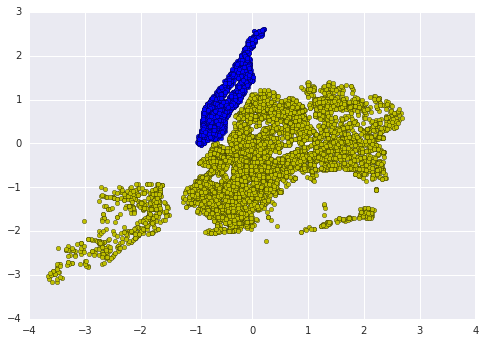

In [84]:
import matplotlib.pyplot as plt
lat = latlng_std[:,0]
lng = latlng_std[:,1]
plt.scatter(lng[is_mt == 1], lat[is_mt == 1], c='b') # plot points in Manhattan in blue
plt.scatter(lng[is_mt == 0], lat[is_mt == 0], c='y') # plot points outside Manhattan in yellow
plt.show()

You can see that the geolocations in Manhattan are plotted in blue dots, and others are in yellow dots. Also, latitudes and longitudes are scaled from 0 to 1.

### Split the data into "Training Data" and "Test Data"

Before start training the neural network model, we need to separate a part of the training data as test data. The test data will be used for checking accuracy of classifications by the model after the training. This is a common practice in machine learning to accurately evaluate the performance of your model.

**Run the cell below** and split the data into 8,000 pairs of training data and 2,000 pairs of test data.

In [117]:
# 8,000 pairs for training
latlng_train = latlng_std[0:8000]
is_mt_train = is_mt[0:8000]

# 2,000 pairs for test
latlng_test = latlng_std[8000:10000]
is_mt_test = is_mt[8000:10000]

print "Split finished."

Split finished.


### Lab: Disscuss the preprocessing

Disscuss with your buddy about the following topics.

- What are the proprocess we have done so far
- Why is each proprocess required
- What function of NumPy and Matplotlib we have used to plot the map
- Why we need to split the data into training and testing.

## 2-3. Train the Neural Network with TensorFlow High level API

<br/>
![](images/tflogo.png)
<br/>

Now, let's use [TensorFlow](https://www.tensorflow.org/).

TensorFlow is an open source library for machine learning. You can define your own neural network or deep learning model and run a training for it on your laptop, or on [many CPUs and GPUs in the cloud](https://cloud.google.com/ml/) for scalable and faster training and prediction.

TensorFlow provides two kind of APIs:

- [High level API](https://www.tensorflow.org/get_started/tflearn): provides easy-to-use [predefined machine learning models](https://www.tensorflow.org/api_guides/python/contrib.learn#estimators)
- [Low level API](https://www.tensorflow.org/get_started/get_started): provides customizable data flow computation framework for machine learning

If you will use common neural network and machine learning models (such as fully-connected neural network, convolutional neural network, logistic regression and k-means), the high level API is recommended. If you want to design your own neural network model with sophisticated or new algorithm, or if you like to learn the underlying technology used for implementing the high level API, the low level API is the best option.

In this codelab, we will use the high level API first, and then look at the low level API to learn more about the underlying technology.

### Define a single layer neural network

**Run the cell below** to define a neural network.

In [118]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) # supress warning messages

# define two feature columns with real values
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=2)]

# create a neural network
dnnc = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[],
  n_classes=3) # need specify 3 instead of 2 (maybe bug?)

dnnc

The code above does the following:

- At line 2, setting the log level to ERROR to supress warning messages
- At line 5, defining "feature columns" (columns in the training data used for training the model) as two dimensional real values
- At line 8, defining a neural network by using [DNNClassifier](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNClassifier) class with the following parameters:
 - No hidden units (= fully connected single layer neural network)
 - Use two classes for classification (Manhattan or not)
 
In a nutshell, this code defines a neural network like this, which is the same single neuron we tried with the Playground, where we put latitude and longitude as input to x1 and x2 respectively.

![](images/singleneuron.png)
![](images/nnformula.png)

Just like we saw the neuron was able to classify the two groups of data points, this time we will train the neuron for classifying whether a geolocation is in Manhattan or not.

### Check the accuracy of the neural network

Before start training the neural network, let's define two methods for checking the accuracy of the neural network. **Run the cell below**.

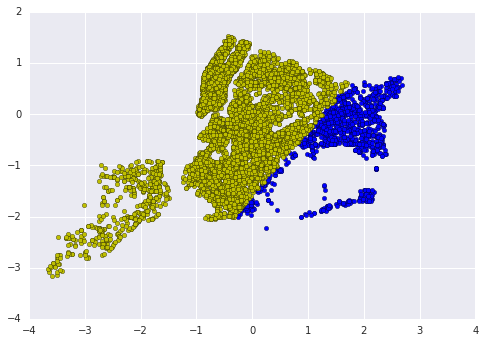

Accuracy: 53.40%


In [119]:
# plot a predicted map of Manhattan
def plot_predicted_map():
  is_mt_pred = dnnc.predict(latlng_std, as_iterable=False) # an array of prediction results
  plt.scatter(lng[is_mt_pred == 1], lat[is_mt_pred == 1], c='b')
  plt.scatter(lng[is_mt_pred == 0], lat[is_mt_pred == 0], c='y')
  plt.show()

# print the accuracy of the neural network 
def print_accuracy():
  accuracy = dnnc.evaluate(x=latlng_test, y=is_mt_test)["accuracy"]
  print('Accuracy: {:.2%}'.format(accuracy))
  
# train the model just for 1 step and print the accuracy
dnnc.fit(x=latlng_train, y=is_mt_train, steps=1)
plot_predicted_map()
print_accuracy()

In the first method `plot_predicted_map()` at line 3, it calls [predict()](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNClassifier#predict) method of `DNNClassifier` class to get an array of prediction results (10,000 rows) like `[1 0 0 1 ... 0 0 1 0]` where `1` means that the neural network believes the geolocation is in Manhattan, and `0` means it's not. By using this array as index for selecting `lat` and `lng`, the method plots geolocations predicted as Manhattan in blue dots and others in yellow dots.

In the second method `print_accuracy()` at line 9, it calls [evaluate()](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Evaluable#evaluate) method of `DNNClassifier` class to calculate the accuracy of the prediction with the test data `latlng_test` and `is_mt_test` and print it.

After defining the two methods, it calls [fit()](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Trainable#fit) method of `DNNClassifier` class at line 14 to train the model for just **one step**. A step in the `fit()` method moves the weights and bias in the neural network only for a little towards the direction of less error. But usually it takes thousands of steps for neural networks to find the best weights and bias. So, what you are seeing shows how the neural network in the initial state (= before the training) gives so low accuracy and can not classify the Manhattan properly. 

### Train the neural network

Finally let's start training the neural network. This time, we will train the network by calling `fit()` method for 500 steps with the training data `latlng_train` and `is_mt_train`. At every 100 steps, it will call `plot_predicted_map()` and `print_accuracy()` to show the current accuracy of the network. **Run the cell below** and wait for a couple of minutes until the message "Finished" is printed. You will see the network is trying to **move the weights and bias slowly** to minimize the error and find the best position of the line for classifying geolocations in Manhattan. The final accuracy would be as high as 95%.

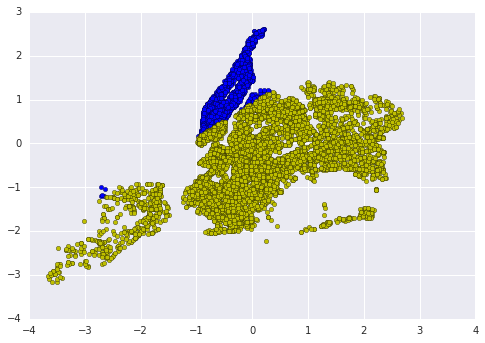

Steps: 100
Accuracy: 94.60%


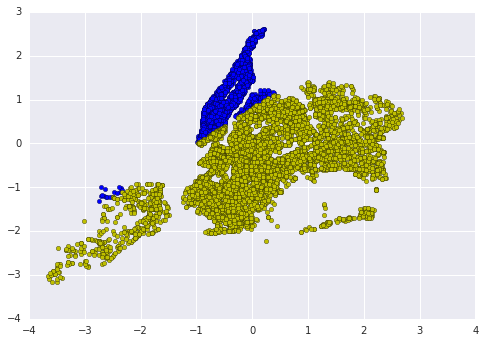

Steps: 200
Accuracy: 96.55%


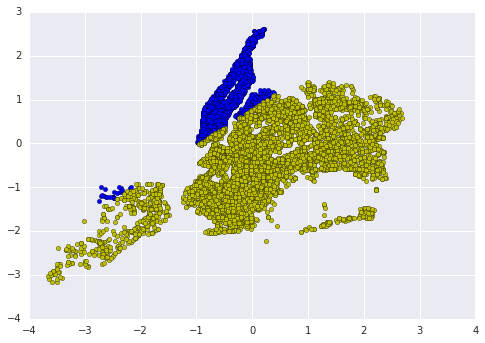

Steps: 300
Accuracy: 96.60%


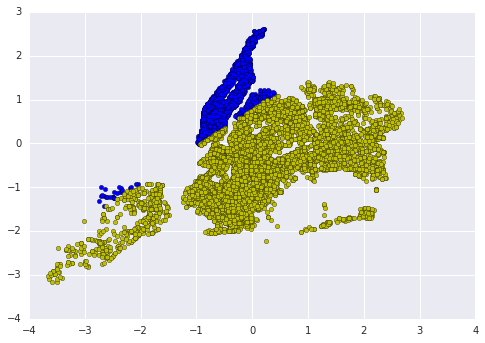

Steps: 400
Accuracy: 97.10%


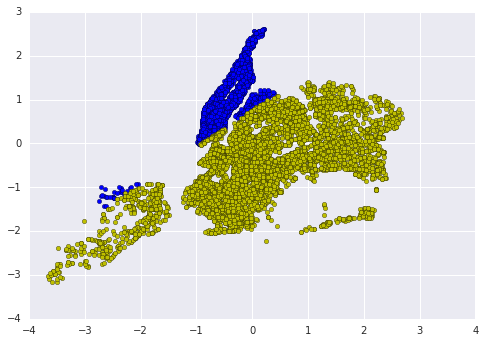

Steps: 500
Accuracy: 97.15%

Training Finished.


In [120]:
steps = 100
for i in range (1, 6):
  dnnc.fit(x=latlng_train, y=is_mt_train, steps=steps)
  plot_predicted_map()
  print 'Steps: ' + str(i * steps)
  print_accuracy()
  
print('\nTraining Finished.')

### Lab: Try training the neural network a couple of times

- Go back to the section "Define a single layer neural network" and run the following cells again to train the network from scratch
- Repeat the training for a couple of times and confirm that the network's max accuracy is around 97%
- Discuss with your buddy what is the reason why the single layer network can't achieve accuracy higher than 97%

## 2-4. Train a Deep Neural Network with TensorFlow

You just saw that the network can only draw **a straight line** on the map and classify a geolocation is in Manhattan or not. So called **Linear Classification**. That is the limitation of the single layer neural network and you can only achieve around 95% accuracy because the straight line (linear classification) can't split the geolocations between Manhattan and Brooklyn with a curved boundary.

We must go deeper. Let's define a deep neural network (DNN). **Run the cell below** to define a new `DNNClassifier`.

In [121]:
dnnc = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20, 20, 20, 20],
  n_classes=3)
dnnc

### The hidden layers give the power

The only difference from the last `DNNClassifier` definition is the `hidden_units` parameter where it defines **4 hidden layers with 20 neurons each**. As the network has total 5 layers, you can call it as a deep neural network ("deep" means you have layers more than 2). 

Let's see how the deep neural network works. **Run the cell below** and wait for a couple of minutes until it finishes the training.

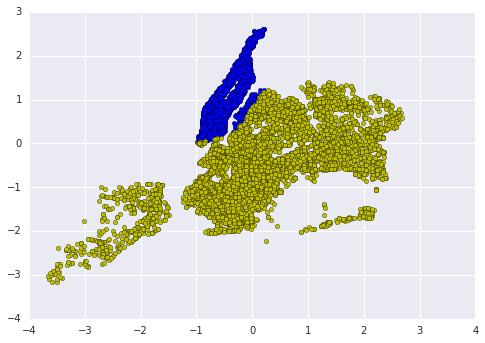

Steps: 30
Accuracy: 98.35%


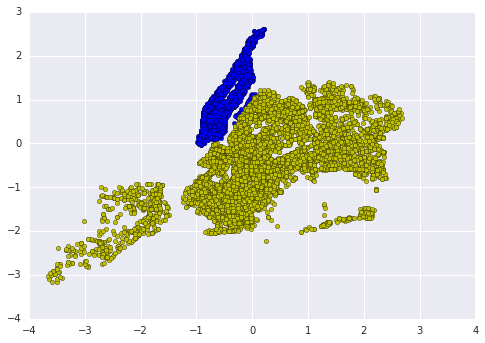

Steps: 60
Accuracy: 99.70%


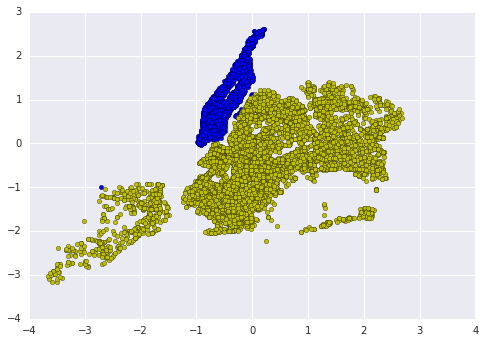

Steps: 90
Accuracy: 99.80%


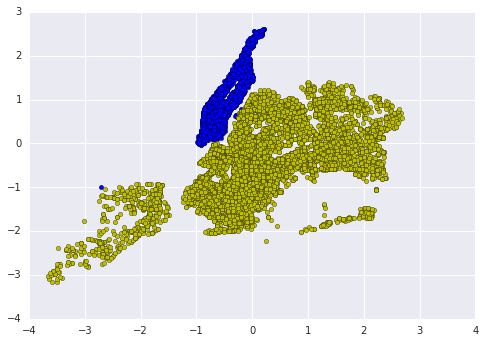

Steps: 120
Accuracy: 99.90%


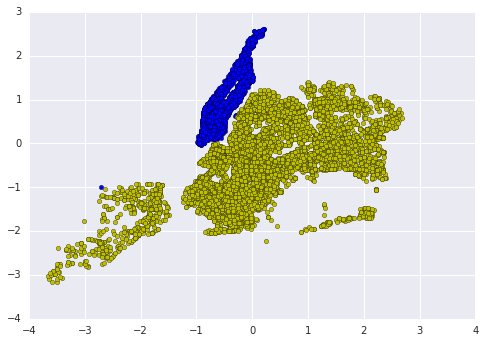

Steps: 150
Accuracy: 99.95%

Training Finished.


In [122]:
steps = 30
for i in range (1, 6):
  dnnc.fit(x=latlng_train, y=is_mt_train, steps=steps)
  plot_predicted_map()
  print 'Steps: ' + str(i * steps)
  print_accuracy()
  
print('\nTraining Finished.')

You just saw that a DNN can classify the geolocations of Manhattan at around 99.9% accuracy with a curved boundary that fits between Manhattan and Brooklyn. In the next section, we will learn why DNN can recognize and extract the complex patterns in the training dataset by using the power of **hidden layers**.

### Lab: Train the network with different configurations

- Reduce the number of hidden layers to 3, 2 and 1 and retry training the network. See how it affect the accuracy
- Reduce the number of nodes in all hidden layers to 10 and retry training the network. See how it affect the accuracy
- Discuss with your buddy what is the reason why the deep neural network can achieve much higher accuracy than the single layer

# What We Learned

In this section, we have learned the following concepts.

- With Cloud Datalab, you can execute **BigQuery SQLs** and import the result, easily able to **preprocess** the training data
- In machine learning, the preprocessing such as **feature scaling** with **standardization** and **splitting into training data and test data** are important procedures before start the training
- In machine learning with Python, you can use popular tools such as **NumPy**, **scikit-learn** and **Matplotlib** for those preprocessing and visualization
- **TensorFlow** provides **High level API** and **Low level API**. You may choose the former for using the common machine learning and neural network models
- **DNNClassifier** class of High-level API let you easily define, train and evaluate a neural network
- Single layer neural network is a **Linear Classifier** so that it has a limitation on recognizing complex patterns in training data
- By using **Deep Neural Network**, you can capture much complex patterns from the training data and can classify them with its **hidden layers**